In [2]:
# Instalar las librerias
# !pip install pandas
# !pip install scikit-learn
# D:\01_MaestriaAnalitica_UnivAndes\07_ML_NLP\S4\Proyecto\pry_pric_cars\venv\Scripts\pip.exe install -r requirements.txt
# !pip install imblearn

In [1]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
import time

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style()

In [2]:
directorio = os.path.split(os.getcwd())[0]
test_df = pd.read_csv(os.path.join("../INPUT/","dataTest_carListings.csv"))
train_df = pd.read_csv(os.path.join("../INPUT/","dataTrain_carListings.csv"))

X = train_df.iloc[:,1:]
y = train_df.iloc[:,0]

X = X.replace(' ', '', regex=True)

#del(train_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
X_train.head(5)

(320000, 5)


,Year,Mileage,State,Make,Model
169018,2008,81249,OH,Chevrolet,Malibu4dr
59736,2017,21122,TX,Toyota,SiennaXLE
366790,2012,124839,CA,Hyundai,Elantra4dr
105379,2015,22329,PA,Lexus,RX
181239,2012,77511,RI,Jeep,PatriotLimited


In [3]:
train_df = X_train.copy()
train_df["Price"] = y

In [4]:
categorical_cols = ["State","Make","Model","Year"]

for c in categorical_cols:
    gr = train_df.groupby(c)[["Price"]].count().reset_index().sort_values(by="Price", ascending = False)
    print(gr.describe())
    print(gr.shape)
    display(gr)

              Price
count     51.000000
mean    6274.509804
std     7449.440345
min        5.000000
25%     1582.000000
50%     3934.000000
75%     8637.000000
max    36855.000000
(51, 2)


,State,Price
43,TX,36855
4,CA,29077
9,FL,27059
10,GA,14621
27,NC,14327
14,IL,13481
45,VA,12677
38,PA,10388
34,NY,10011
31,NJ,9711


              Price
count     38.000000
mean    8421.052632
std    12475.311983
min        5.000000
25%      834.750000
50%     2566.000000
75%    10708.250000
max    50156.000000
(38, 2)


,Make,Price
10,Ford,50156
6,Chevrolet,46742
35,Toyota,36755
13,Honda,26473
17,Jeep,19564
12,GMC,16662
18,Kia,13092
8,Dodge,12967
14,Hyundai,11950
20,Lexus,10982


              Price
count    525.000000
mean     609.523810
std     1091.006802
min       38.000000
25%      117.000000
50%      273.000000
75%      693.000000
max    14458.000000
(525, 2)


,Model,Price
417,Silverado,14458
248,Grand,9931
416,Sierra,6681
40,Accord,5856
187,F-1504WD,5315
...,...,...
376,RX-84dr,41
383,RegalGS,40
339,PathfinderSE,40
303,Monte,39


              Year         Price
count    22.000000     22.000000
mean   2007.500000  14545.454545
std       6.493587  18273.464146
min    1997.000000     83.000000
25%    2002.250000    687.250000
50%    2007.500000   7150.000000
75%    2012.750000  23314.500000
max    2018.000000  57192.000000
(22, 2)


,Year,Price
18,2015,57192
17,2014,54269
19,2016,44786
20,2017,35963
16,2013,25942
15,2012,24725
14,2011,19083
13,2010,13279
11,2008,10786
10,2007,8824


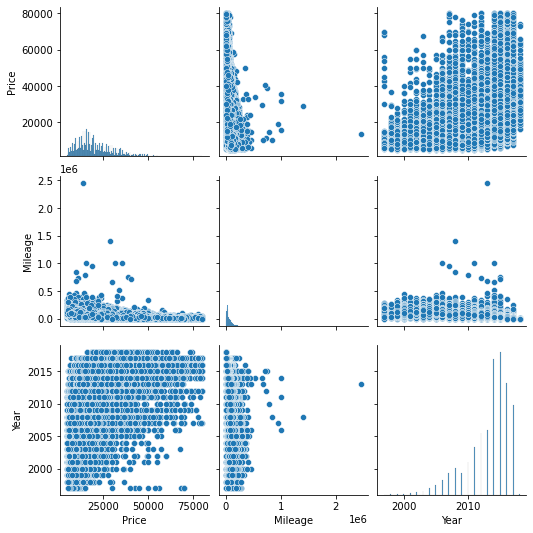

In [5]:
continuous_cols = ["Price","Mileage","Year"]
sns.pairplot(train_df[continuous_cols])

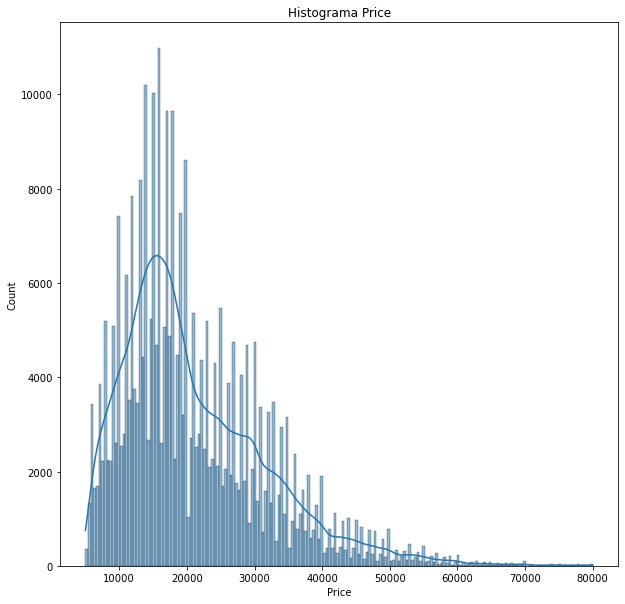

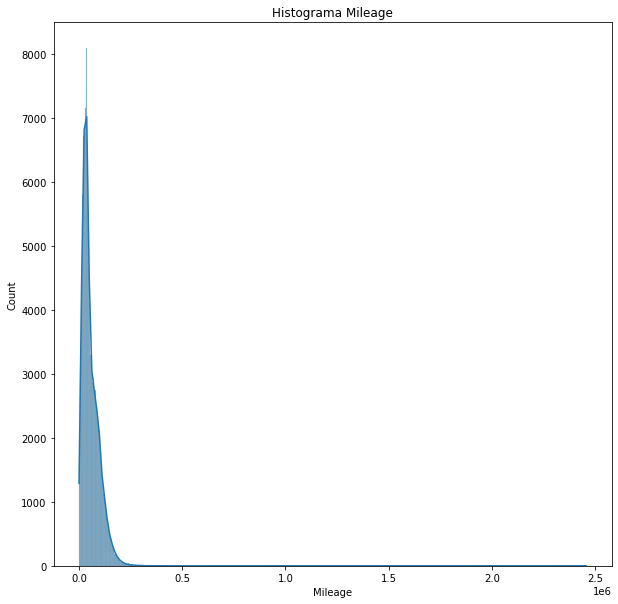

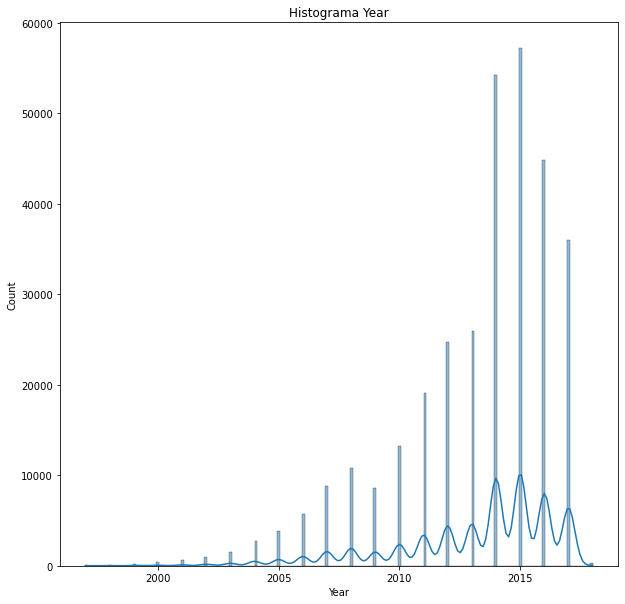

In [6]:
for c in continuous_cols:
    fig, ax = plt.subplots(figsize=(10,10))
    sns.histplot(data=train_df, x=c, kde=True, ax = ax)
    ax.set_title("Histograma {}".format(c))

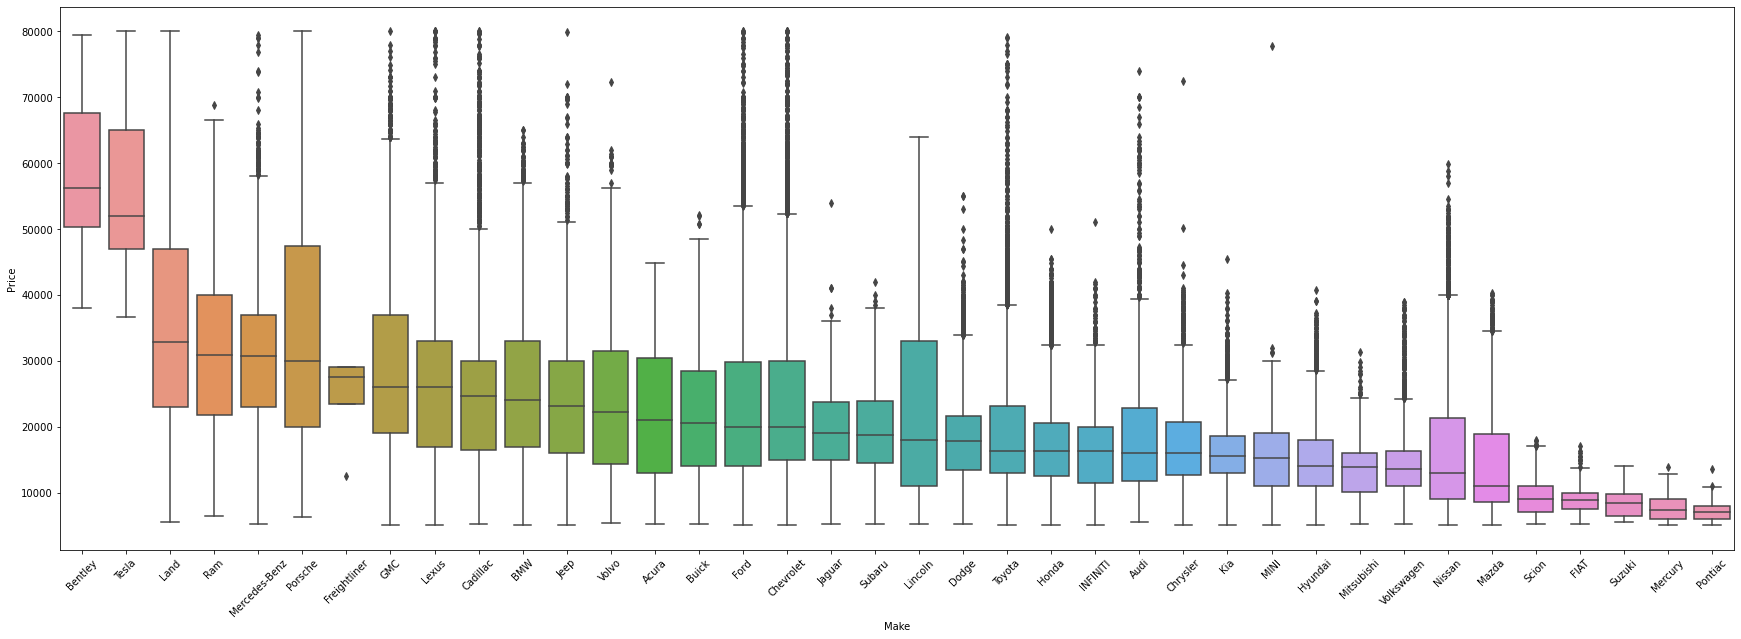

In [7]:
fig, ax = plt.subplots(figsize=(30,10))

violin_order = train_df.groupby("Make")[["Price"]].median().reset_index().sort_values(by="Price", ascending=False)["Make"]

sns.boxplot(data=train_df, x="Make", y="Price", order=violin_order)
plt.xticks(rotation=45);

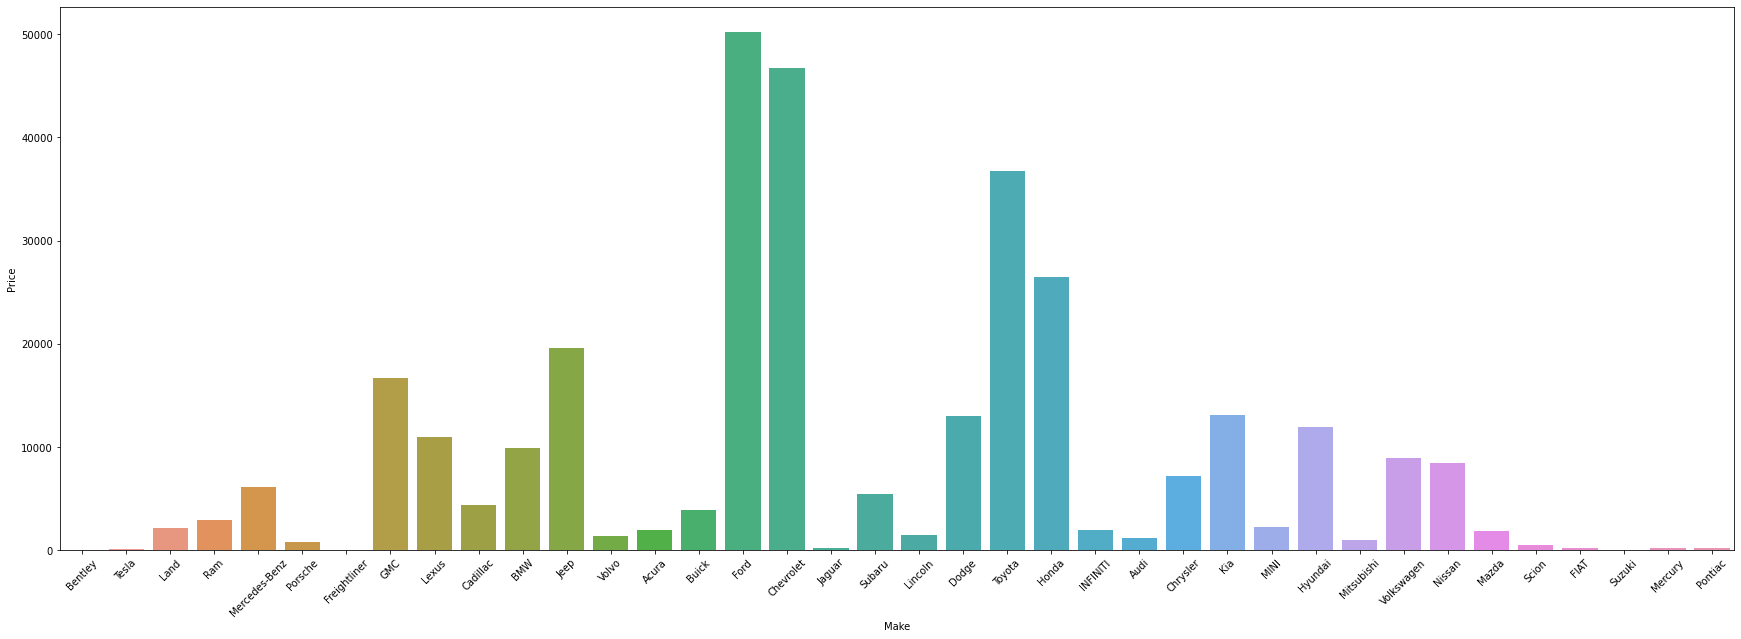

In [8]:
gr = train_df.groupby("Make")[["Price"]].count().reset_index().sort_values(by="Price", ascending = False)
fig, ax = plt.subplots(figsize=(30,10))

sns.barplot(data=gr, x = "Make", y= "Price",order=violin_order)
plt.xticks(rotation=45);

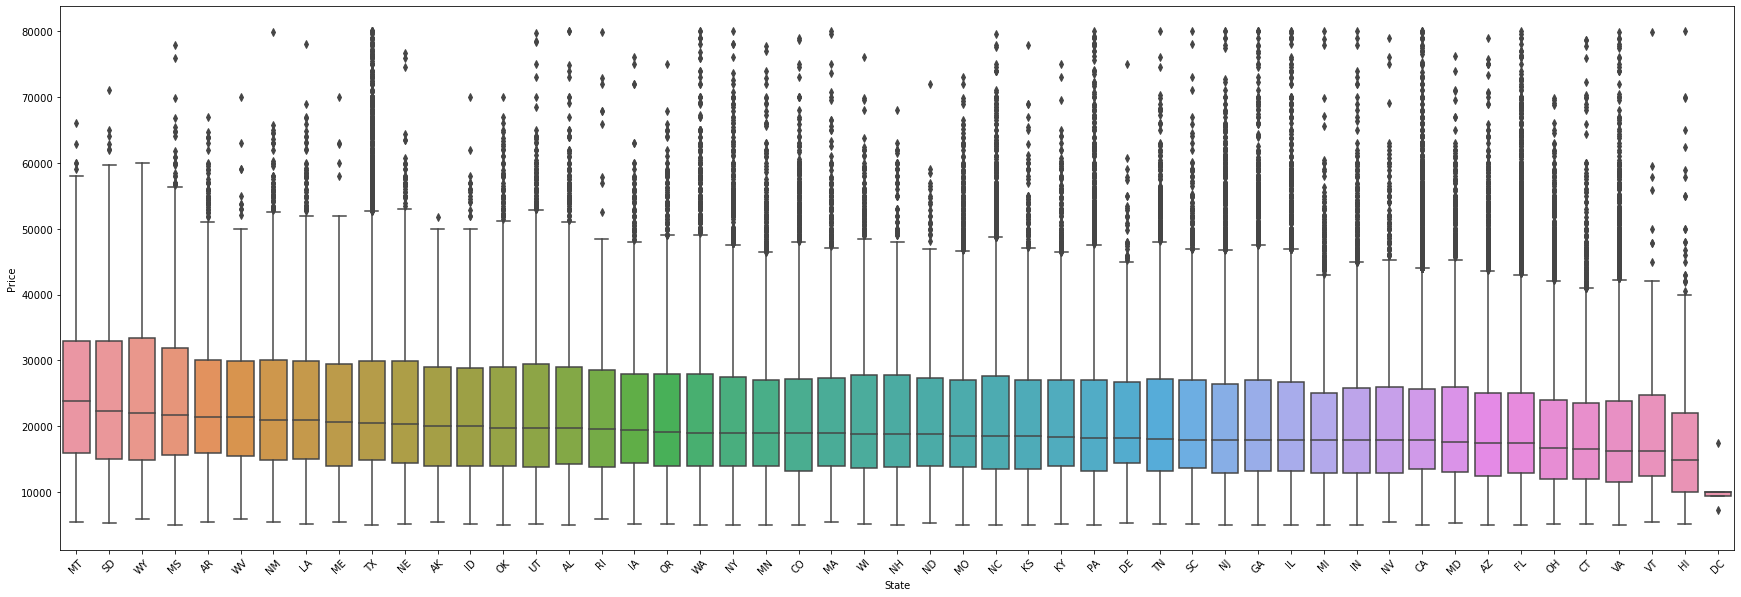

In [9]:
fig, ax = plt.subplots(figsize=(30,10))

violin_order = train_df.groupby("State")[["Price"]].median().reset_index().sort_values(by="Price", ascending=False)["State"]

sns.boxplot(data=train_df, x="State", y="Price", order=violin_order)
plt.xticks(rotation=45);

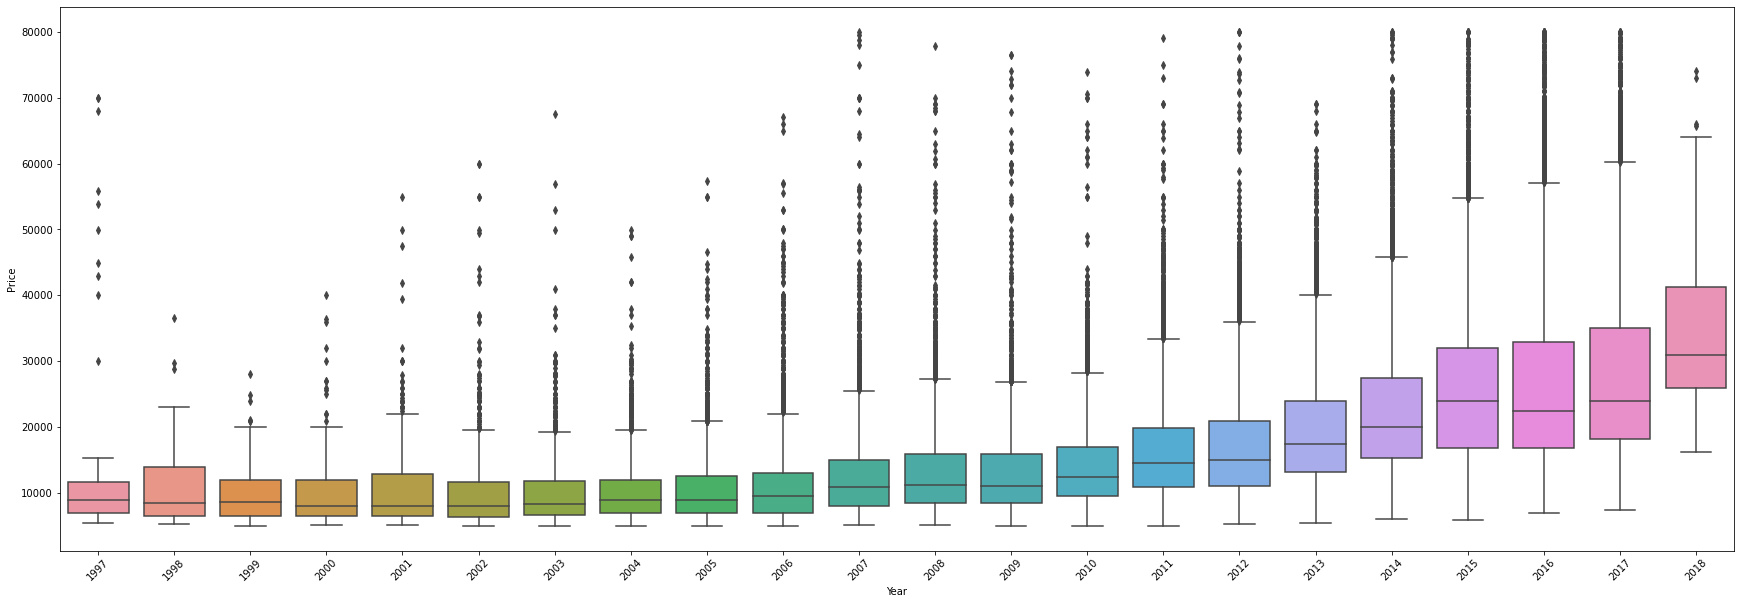

In [10]:
fig, ax = plt.subplots(figsize=(30,10))

sns.boxplot(data=train_df, x="Year", y="Price")
plt.xticks(rotation=45);

In [11]:
train_df.groupby(["Make","Model"])[["Price"]].median().reset_index().sort_values(by="Price", ascending=False).head(29)

,Make,Model,Price
25,Bentley,Continental,56239.0
191,Ford,MustangShelby,52747.5
361,Mercedes-Benz,E-ClassE,52050.0
437,Tesla,Model,51995.0
468,Toyota,Land,50999.0
535,Volvo,XC90T6,50958.0
59,Chevrolet,CorvetteConvertible,49999.0
60,Chevrolet,CorvetteCoupe,47995.0
216,GMC,Yukon4WD,46492.5
333,Lexus,LX,46040.0


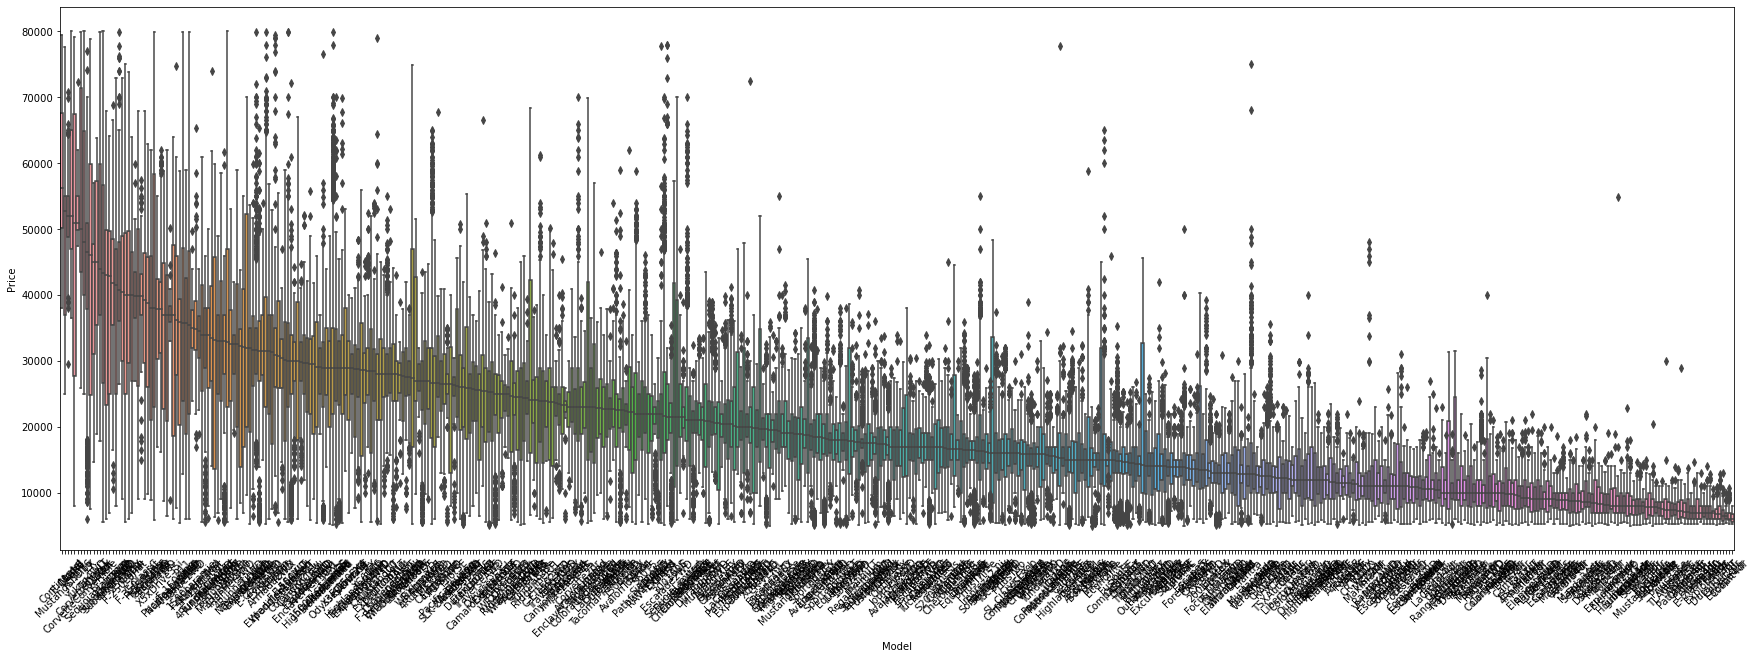

In [12]:
fig, ax = plt.subplots(figsize=(30,10))

violin_order = train_df.groupby("Model")[["Price"]].median().reset_index().sort_values(by="Price", ascending=False)["Model"]

sns.boxplot(data=train_df, x="Model", y="Price", order=violin_order)
plt.xticks(rotation=45);

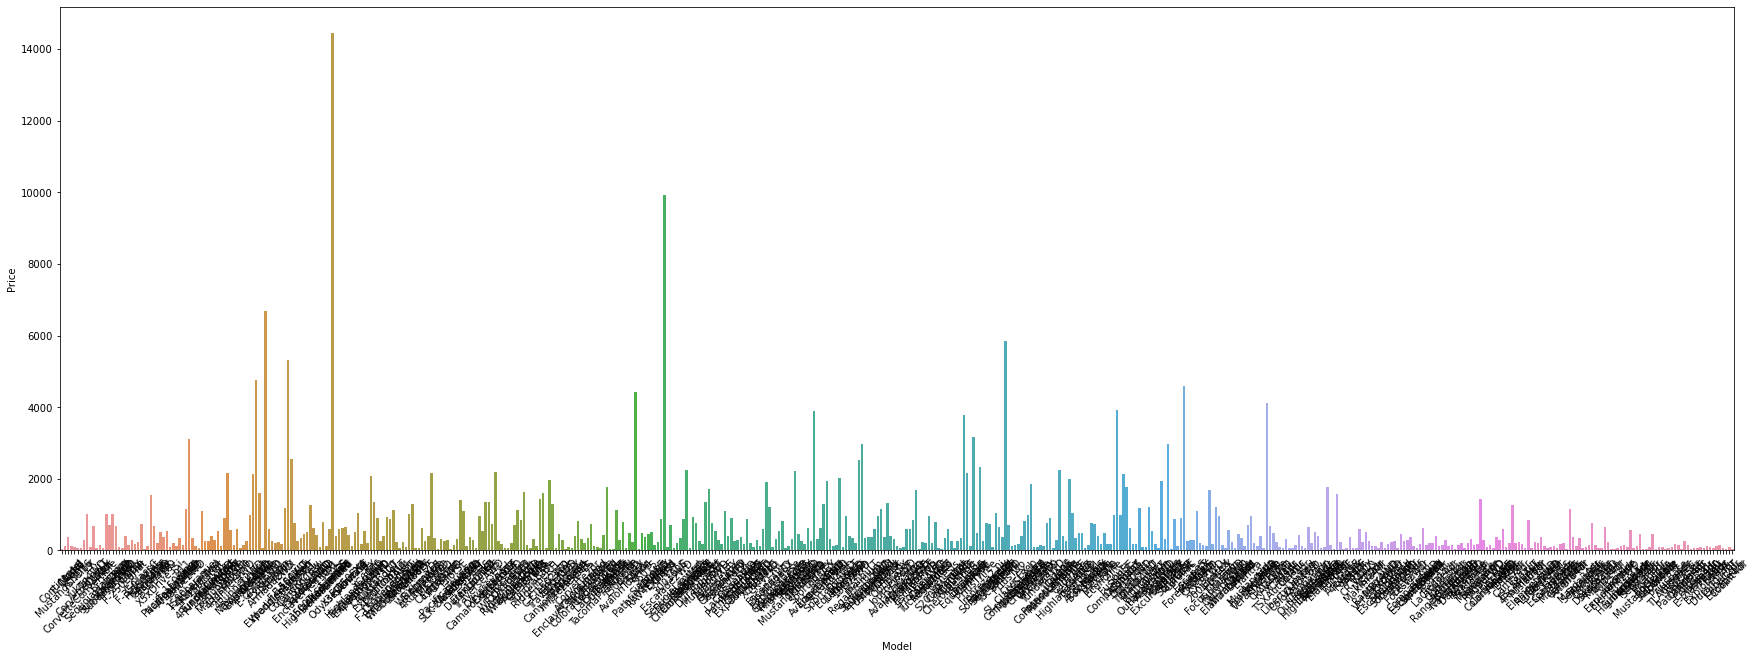

In [13]:
gr = train_df.groupby("Model")[["Price"]].count().reset_index().sort_values(by="Price", ascending = False)
fig, ax = plt.subplots(figsize=(30,10))

sns.barplot(data=gr, x = "Model", y= "Price",order=violin_order)
plt.xticks(rotation=45);

In [15]:
gr["pct"] = gr["Price"]/ gr["Price"].sum()
gr["cumsum"] = gr["pct"].cumsum()
gr.head(40).T

,417,248,416,40,187,489,104,11,264,233,...,88,186,458,335,66,129,149,124,326,146
Model,Silverado,Grand,Sierra,Accord,F-1504WD,Wrangler,Civic,3,Jetta,FusionSE,...,CamryLE,F-1502WD,TerrainFWD,Passat4dr,CR-VEX-L,CruzeSedan,Elantra4dr,CorollaS,Outback2.5i,EdgeSEL
Price,14458,9931,6681,5856,5315,4756,4602,4421,4125,3930,...,1988,1979,1938,1929,1915,1853,1782,1779,1770,1713
pct,0.045181,0.031034,0.020878,0.0183,0.016609,0.014863,0.014381,0.013816,0.012891,0.012281,...,0.006213,0.006184,0.006056,0.006028,0.005984,0.005791,0.005569,0.005559,0.005531,0.005353
cumsum,0.045181,0.076216,0.097094,0.115394,0.132003,0.146866,0.161247,0.175063,0.187953,0.200234,...,0.3659,0.372084,0.378141,0.384169,0.390153,0.395944,0.401512,0.407072,0.412603,0.417956


# Transformacion de datos

In [5]:
from sklearn.cluster import KMeans

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

### Make Cluster

c:\Users\paulg\anaconda3\envs\nlp_proyect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\paulg\anaconda3\envs\nlp_proyect\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\paulg\anaconda3\envs\nlp_proyect\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\paulg\anaconda3\envs\nlp_proyect\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there

{'1': 9, '15002WD': 5, '15004WD': 2, '1500Laramie': 8, '1500Tradesman': 1, '200LX': 0, '200Limited': 9, '200S': 9, '200Touring': 0, '25002WD': 1, '25004WD': 3, '3': 2, '300300C': 2, '300300S': 4, '3004dr': 0, '300Base': 5, '300Limited': 2, '300Touring': 6, '35004WD': 8, '350Z2dr': 0, '4Runner2WD': 1, '4Runner4WD': 8, '4Runner4dr': 6, '4RunnerLimited': 8, '4RunnerRWD': 4, '4RunnerSR5': 1, '4RunnerTrail': 8, '5': 4, '500Pop': 6, '6': 8, '7': 8, '911': 8, '9112dr': 3, 'A34dr': 0, 'A44dr': 0, 'A64dr': 9, 'A8': 3, 'AcadiaAWD': 4, 'AcadiaFWD': 4, 'Accent4dr': 6, 'Accord': 5, 'AccordEX': 9, 'AccordEX-L': 5, 'AccordLX': 9, 'AccordLX-S': 9, 'AccordSE': 0, 'Altima4dr': 6, 'Armada2WD': 1, 'Armada4WD': 8, 'Avalanche2WD': 5, 'Avalanche4WD': 5, 'Avalon4dr': 0, 'AvalonLimited': 2, 'AvalonTouring': 2, 'AvalonXLE': 2, 'Azera4dr': 6, 'Boxster2dr': 9, 'C-Class4dr': 9, 'C-ClassC': 3, 'C-ClassC300': 1, 'C-ClassC350': 4, 'C702dr': 0, 'CC4dr': 0, 'CR-V2WD': 0, 'CR-V4WD': 0, 'CR-VEX': 5, 'CR-VEX-L': 2, 'CR-VL

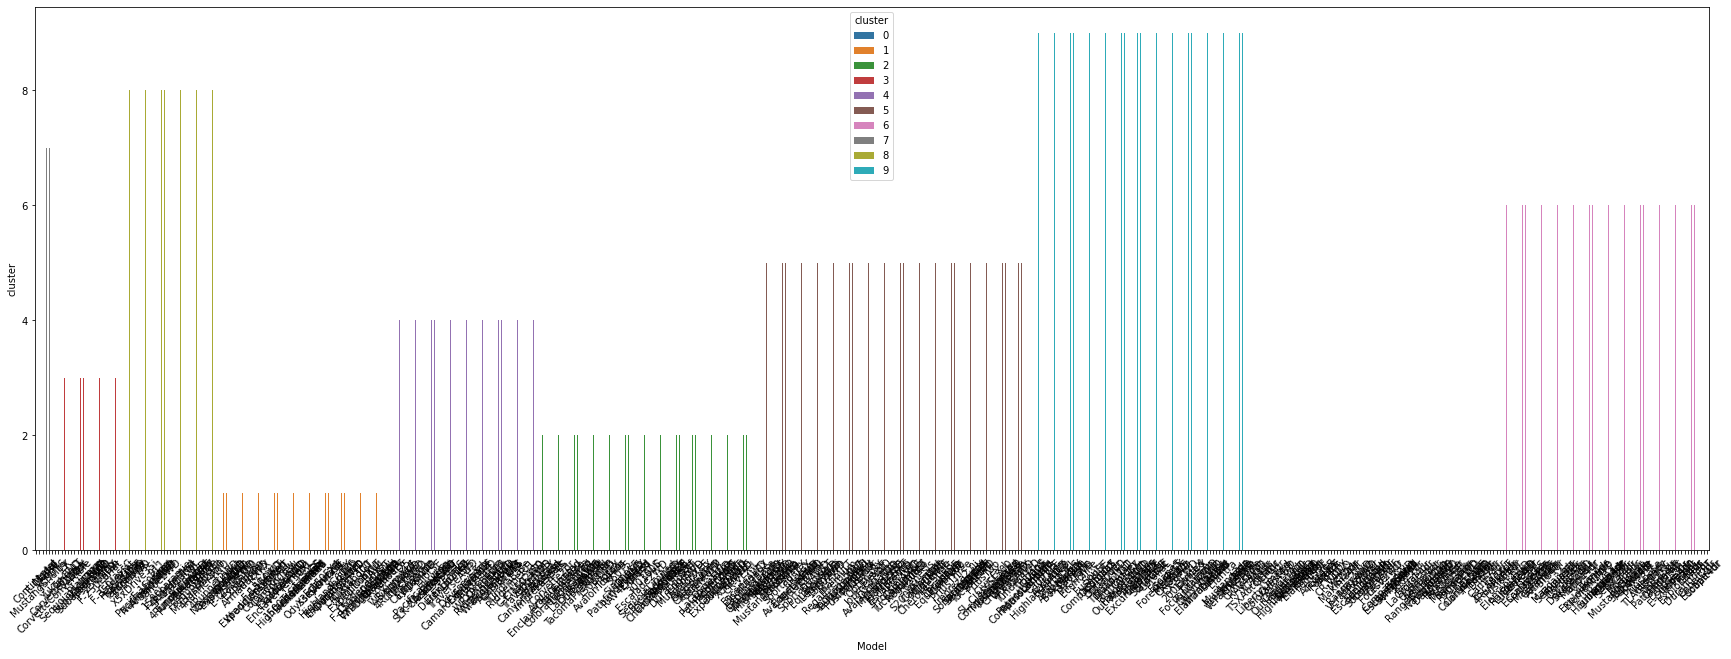

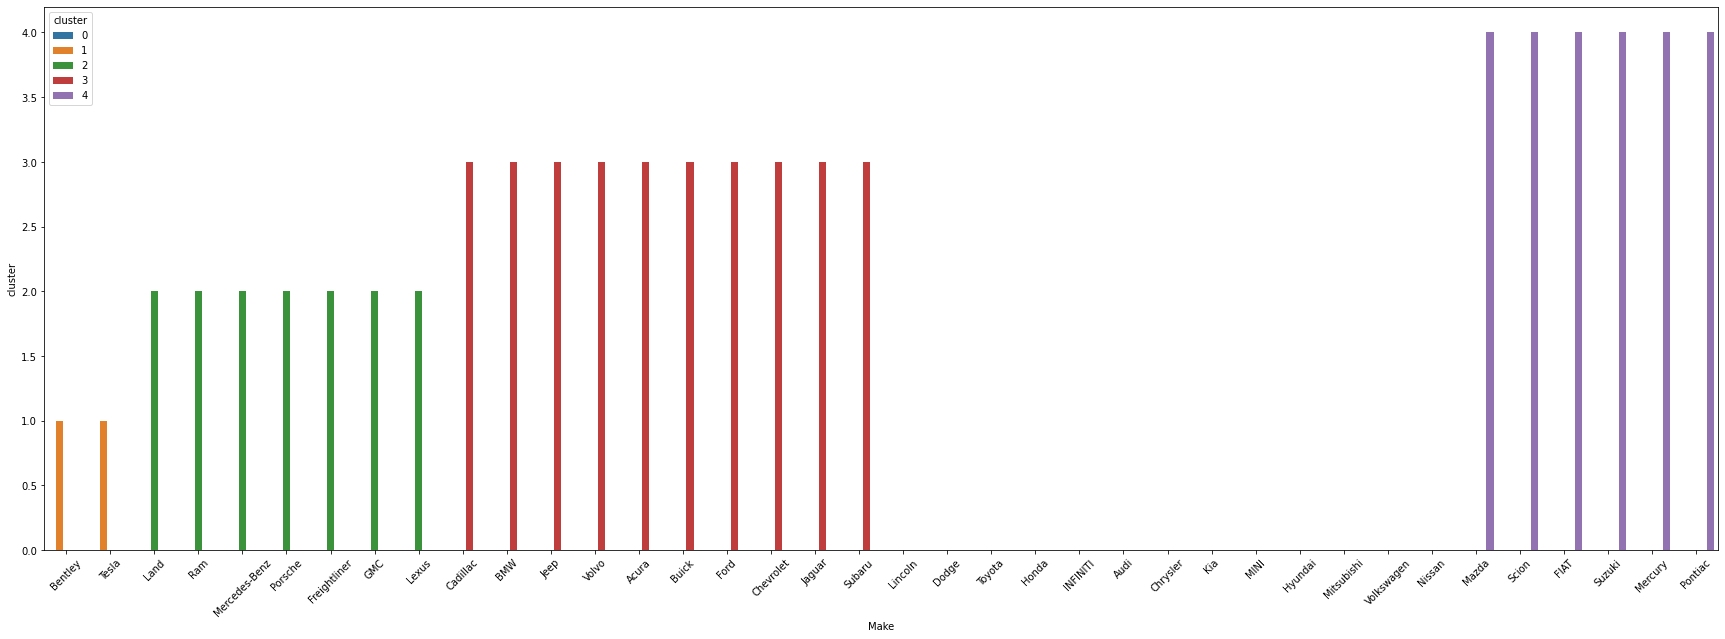

In [6]:
def clusterizar_variables(col, n_clusters):

    kmeans = KMeans(n_clusters=n_clusters, random_state=12)
    encoder = OneHotEncoder()

    train_df

    train_df[col] = train_df[col].astype(str)

    price_metric = train_df[[col,"Price"]].groupby([col])["Price"].median().reset_index()


    encoder.fit(price_metric[[col]])
    kmeans_df = price_metric[["Price"]].join(pd.DataFrame(encoder.transform(price_metric[[col]]).toarray()))
    predict = kmeans.fit_predict(kmeans_df)

    kmeans_df["cluster"] = predict

    price_metric = price_metric[[col,"Price"]].join(kmeans_df[["cluster"]])


    order = price_metric.sort_values(by="Price", ascending=False)[col]

    fig, ax = plt.subplots(figsize=(30,10))

    sns.barplot(data=price_metric, x = col, y= "cluster",order=order, hue="cluster",ax=ax)
    plt.xticks(rotation=45);

    dict_clusters = dict(zip(price_metric[col], price_metric["cluster"]))

    return dict_clusters


dict_models = clusterizar_variables(col="Model", n_clusters = 10)
dict_maker = clusterizar_variables(col="Make", n_clusters = 5)
print(dict_models)
print(dict_maker)

In [7]:
categorical_cols = ["Make","Model"]

for c in categorical_cols:
    gr = train_df.groupby(c)[["Price"]].count().reset_index().sort_values(by="Price", ascending = False)
    print(gr.describe())
    print(gr.shape)
    display(gr.T)

              Price
count     38.000000
mean    8421.052632
std    12475.311983
min        5.000000
25%      834.750000
50%     2566.000000
75%    10708.250000
max    50156.000000
(38, 2)


,10,6,35,13,17,12,18,8,14,20,...,29,31,16,28,9,25,34,3,33,11
Make,Ford,Chevrolet,Toyota,Honda,Jeep,GMC,Kia,Dodge,Hyundai,Lexus,...,Porsche,Scion,Jaguar,Pontiac,FIAT,Mercury,Tesla,Bentley,Suzuki,Freightliner
Price,50156,46742,36755,26473,19564,16662,13092,12967,11950,10982,...,774,518,258,229,216,213,125,50,30,5


              Price
count    525.000000
mean     609.523810
std     1091.006802
min       38.000000
25%      117.000000
50%      273.000000
75%      693.000000
max    14458.000000
(525, 2)


,417,248,416,40,187,489,104,11,264,233,...,17,245,263,515,202,376,383,339,303,397
Model,Silverado,Grand,Sierra,Accord,F-1504WD,Wrangler,Civic,3,Jetta,FusionSE,...,300Touring,Galant4dr,ImprezaSport,Yaris4dr,F-350King,RX-84dr,RegalGS,PathfinderSE,Monte,SLK-ClassSLK350
Price,14458,9931,6681,5856,5315,4756,4602,4421,4125,3930,...,45,44,43,43,43,41,40,40,39,38


In [8]:
from joblib import dump, load

col_dummies = ['Make','State','cluster_make','cluster_model']

X["cluster_make"] = X["Make"].map(dict_maker).fillna(-1)
X["cluster_model"] = X["Model"].map(dict_models).fillna(-1)

encoder = OneHotEncoder(drop='first',handle_unknown='ignore')
encoder.fit(X[col_dummies])

max_categorias = 30
encoder_model = OneHotEncoder(drop='first',handle_unknown='ignore', max_categories=max_categorias)
encoder_model.fit(X[["Model"]])

#dump(encoder, '../OUTPUT/onehot_encoder_variables_model_1.bin', compress=True)
dump(encoder_model, '../OUTPUT/onehot_model_variables_model_1.bin', compress=True)

X = X.drop(columns=["cluster_make","cluster_model"])

In [9]:
import re
def  extraer_lineas(modelo_veh):
    patron_version = re.compile("[A-Z]{2,}")
    extraccion = re.findall(patron_version,modelo_veh)

    if len(extraccion)>0:
        extraccion = extraccion[0]
    else:
        patron_4puerta = re.compile("4dr$")
        extraccion = re.findall(patron_4puerta,modelo_veh)
        
        if len(extraccion)>0:
            extraccion = '4doors'
        else:
            extraccion = 'No_version'

    return extraccion


def transformar_train(X, mx_year,dict_maker, dict_models, encoder_model):
    
    X["cluster_make"] = X["Make"].map(dict_maker).fillna(-1)
    X["cluster_model"] = X["Model"].map(dict_models).fillna(-1)
    X["Age"] = mx_year - X["Year"]
    X["Version"] = X["Model"].apply(extraer_lineas)
    X["Mileage"] = np.log(X["Mileage"])

    
    col_dummies = ['Make','State','cluster_make','cluster_model','Version']

    encoder = OneHotEncoder(drop='first',handle_unknown='ignore')
    encoder.fit(X[col_dummies])

    X = pd.concat([X,pd.DataFrame(encoder.transform(X[col_dummies]).toarray(), columns = encoder.get_feature_names_out(), index = X.index)], axis = 1)
    X = X.drop(columns=col_dummies)

    encoder_model.fit(X[["Model"]])

    X = pd.concat([X,pd.DataFrame(encoder_model.transform(X[["Model"]]).toarray(), columns = encoder_model.get_feature_names_out(), index = X.index)], axis = 1)
    X = X.drop(columns="Model")

    return X, encoder

def transformar(X, mx_year,dict_maker, dict_models, encoder_model, encoder_variables):
    
    X["cluster_make"] = X["Make"].map(dict_maker).fillna(-1)
    X["cluster_model"] = X["Model"].map(dict_models).fillna(-1)
    X["Age"] = mx_year - X["Year"]
    X["Version"] = X["Model"].apply(extraer_lineas)
    X["Mileage"] = np.log(X["Mileage"])
    #X["Mileage"] = np.log(X.loc[:,"Mileage"])

    col_dummies = ['Make','State','cluster_make','cluster_model','Version']

    encoder = encoder_variables

    X = pd.concat([X,pd.DataFrame(encoder.transform(X[col_dummies]).toarray(), columns = encoder.get_feature_names_out(), index = X.index)], axis = 1)
    X = X.drop(columns=col_dummies)

    X = pd.concat([X,pd.DataFrame(encoder_model.transform(X[["Model"]]).toarray(), columns = encoder_model.get_feature_names_out(), index = X.index)], axis = 1)
    X = X.drop(columns="Model")

    return X

In [10]:
#Año para calcular la edad
mx_year = X_train["Year"].max()

X_train_transformed, encoder = transformar_train(X_train,mx_year,dict_maker, dict_models,encoder_model)

dump(encoder, '../OUTPUT/onehot_encoder_variables_model_1.bin', compress=True)
X_train_transformed.shape

(320000, 208)

In [11]:
X_test_transformed = transformar(X_test,mx_year,dict_maker, dict_models,encoder_model, encoder_variables=encoder)
X_test_transformed.shape

(80000, 208)

# Modelo

In [12]:
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

clf = XGBRegressor(random_state=1, tree_method  = "hist", learning_rate = 0.6600000000000004, n_estimators=150)

# Entrenamiento (fit) y desempeño del modelo XGBClassifier
clf.fit(X_train_transformed, y_train)
y_pred = clf.predict(X_test_transformed)


mae_XBoost = mean_absolute_error(y_test, y_pred)
rmse_XBoost = np.sqrt(mean_squared_error(y_test, y_pred))


print(mae_XBoost, rmse_XBoost)
#2384.971994708252 3701.102270528838
#2355.9571417022703 3681.8335001574997

2363.7754663665773 3684.4102363996535


#### Calibracion Hiperparametros

La mejor tasa de aprendizaje para el modelo es igual a 0.6600000000000004
Error 3701.102270528838


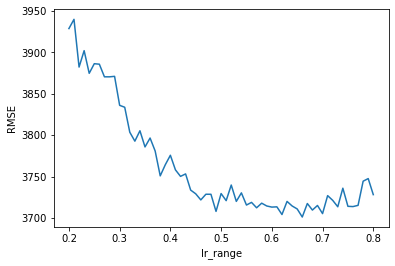

In [224]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
lr_range = np.arange(0.2, 0.8, 0.01)
#lr_range = np.logspace(-5, 0)

# Definición de lista para almacenar el mae y rmse para cada valor de n_estimators
mae_arr = []
rmse_arr = []

# Uso de un 10-fold cross-validation para cada valor de n_estimators
for lr in lr_range:

    clf = XGBRegressor(random_state=1, learning_rate=lr, tree_method  = "gpu_hist")

    clf.fit(X_train_transformed, y_train)
    y_pred = clf.predict(X_test_transformed)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mae_arr.append(mae)
    rmse_arr.append(rmse)

    
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(lr_range, rmse_arr)
plt.xlabel('lr_range')
plt.ylabel('RMSE')


mensaje = ['La mejor tasa de aprendizaje para el modelo es igual a',str(lr_range[np.argmin(rmse_arr)])]
mensaje_err = ['Error',str(rmse_arr[np.argmin(rmse_arr)])]
print(" ".join(mensaje))
print(" ".join(mensaje_err))

In [193]:
lr_range[np.argmin(rmse_arr)]

0.6600000000000004

In [12]:
from sklearn.model_selection import GridSearchCV

xgb1 = XGBRegressor(learning_rate=0.6600000000000004, random_state=1, tree_method  = "gpu_hist")
parameters = {'nthread':[10], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'max_depth': [3],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [10,20]
              }

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=3)


xgb_grid.fit(X_train_transformed,y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[16:25:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:25:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=0.6600000000000004,
                                    max_bi...
                                    max_leaves=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=1, reg_alpha=None,
                                    reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7], 'max_depth': [3],
                         'min_child_weight': [4], 'n_estimators': [10, 20],
                         'nthread': [10], 'objective': ['reg:linear'],
                         'silent': [1], 'subsample': [0.7]},
             verbose=3)

In [13]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'max_depth': 3,
 'min_child_weight': 4,
 'n_estimators': 20,
 'nthread': 10,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}

In [36]:
y_pred = xgb_grid.best_estimator_.predict(X_test_transformed)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(mae, rmse)

2737.639107761383 4110.827830950046


In [68]:
X_train_transformed.shape

(275090, 208)

In [19]:
from sklearn.ensemble import BaggingRegressor

xgr_bag = XGBRegressor(learning_rate=0.6600000000000004, random_state=1, tree_method  = "gpu_hist")

bgr = BaggingRegressor(n_estimators=10, n_jobs=8, random_state=12, base_estimator= xgr_bag)

bgr.fit(X_train_transformed, y_train)
y_pred = bgr.predict(X_test_transformed)


mae_bgr = mean_absolute_error(y_test, y_pred)
rmse_bgr = np.sqrt(mean_squared_error(y_test, y_pred))

print(mae_bgr, rmse_bgr)


2329.727932955933 3635.2259332286153


In [90]:
X_train_transformed.shape[1]

208

In [25]:
from sklearn.ensemble import BaggingRegressor

xgr_bag = XGBRegressor(learning_rate=0.6600000000000004, random_state=1, tree_method  = "gpu_hist", n_estimators=150)


bgr2 = BaggingRegressor(n_estimators=50, n_jobs=10, random_state=12, base_estimator= xgr_bag, max_features=170, verbose=3)

bgr2.fit(X_train_transformed, y_train)
y_pred = bgr2.predict(X_test_transformed)


mae_bgr = mean_absolute_error(y_test, y_pred)
rmse_bgr = np.sqrt(mean_squared_error(y_test, y_pred))

print(mae_bgr, rmse_bgr)
#2415.3146949035645 3735.7385886180787
#2378.7994922851562 3684.777714352606

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


In [1]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
lr_range = np.arange(0.2, 0.8, 0.01)
n_estimators_range = [10,100,500]
#lr_range = np.logspace(-5, 0)

# Definición de lista para almacenar el mae y rmse para cada valor de n_estimators
mae_arr = []
rmse_arr = []

# Uso de un 10-fold cross-validation para cada valor de n_estimators
for n in n_estimators_range:

    xgr_bag = XGBRegressor(learning_rate=0.5300000000000002, random_state=1, tree_method  = "gpu_hist")

    bgr = BaggingRegressor(n_estimators=n, n_jobs=8, random_state=12, base_estimator= xgr_bag)

    bgr.fit(X_train_transformed, y_train)
    y_pred = bgr.predict(X_test_transformed)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    mae_arr.append(mae)
    rmse_arr.append(rmse)

    
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(lr_range, rmse_arr)
plt.xlabel('lr_range')
plt.ylabel('RMSE')


mensaje = ['La mejor tasa de aprendizaje para el modelo es igual a',str(lr_range[np.argmin(rmse_arr)])]
print(" ".join(mensaje))

NameError: name 'np' is not defined

In [200]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(learning_rate=0.5300000000000002, random_state=1)

#bgr = BaggingRegressor(n_estimators=10, n_jobs=8, random_state=12, base_estimator= xgr_bag)

gbr.fit(X_train_transformed, y_train)
y_pred = gbr.predict(X_test_transformed)


mae_bgr = mean_absolute_error(y_test, y_pred)
rmse_bgr = np.sqrt(mean_squared_error(y_test, y_pred))

print(mae_bgr, rmse_bgr)

ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [22]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingRegressor

clf = XGBRegressor(learning_rate=0.6600000000000004, random_state=1, tree_method  = "gpu_hist")
#bgr = BaggingRegressor(n_estimators=10, n_jobs=8, random_state=12, base_estimator=clf)

estimators = [
    ("xgb" , make_pipeline(clf)),
    ("bgr", make_pipeline(bgr))
    ]
stk = StackingRegressor(estimators=estimators, n_jobs=-1) 
y_train_log = np.log(y_train/1000)
stk.fit(X_train_transformed, y_train_log)

y_pred = stk.predict(X_test_transformed)
y_pred = np.exp(y_pred)*1000

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [53]:
mae_rfr = mean_absolute_error(y_test, y_pred)
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred))

print(mae_rfr, rmse_rfr)
#2572.024221169937 3933.892222539083
#2505.1545289984783 3913.8686681779286

2505.450899624098 3913.456176103339


In [62]:
from sklearn.ensemble import VotingRegressor

clf = XGBRegressor(learning_rate=0.5300000000000002, random_state=1, tree_method  = "gpu_hist")
bgr = BaggingRegressor(n_estimators=10, n_jobs=8, random_state=12, base_estimator=clf)

estimators = [
    ("xgb" , make_pipeline(clf)),
    ("bgr", make_pipeline(bgr))
    ]
stk = VotingRegressor(estimators=estimators, n_jobs=-1) 
y_train_log = np.log(y_train/1000)
stk.fit(X_train_transformed, y_train_log)

y_pred = stk.predict(X_test_transformed)
y_pred = np.exp(y_pred)*1000

In [63]:
mae_rfr = mean_absolute_error(y_test, y_pred)
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred))

print(mae_rfr, rmse_rfr)

2510.5473122680664 3923.091259237929


In [13]:
from joblib import dump, load
# Cuando se seleccione el mejor modelo, se almacena
dump(clf, '../OUTPUT/bgr_model_3.bin', compress=True)

['../OUTPUT/bgr_model_3.bin']

In [58]:
import json
data = {'another_dict': {'a': 0, 'b': 1}, 'a_list': [0, 1, 2, 3]}
# e.g. file = './data.json' 
with open('../OUTPUT/dict_models.json', 'w') as f: 
    json.dump(dict_models, f)

with open('../OUTPUT/dict_maker.json', 'w') as f: 
    json.dump(dict_maker, f)

### Importar modelo y variables necesarias para el funcionamiento

In [82]:
from joblib import dump, load
import json

stk = load('../OUTPUT/stacked_xgb_bgr_model_1.bin')
encoder = load('../OUTPUT/onehot_encoder_variables_model_1.bin')
encoder_model = load('../OUTPUT/onehot_model_variables_model_1.bin')

with open('../OUTPUT/dict_models.json', 'r') as f:
    dict_models = json.load(f)

with open('../OUTPUT/dict_maker.json', 'r') as f:
    dict_maker = json.load(f) 


# Preparacion kaggle

In [23]:
kaggle_df = pd.read_csv("../INPUT/dataTest_carListings.csv")

In [25]:
kaggle_transformed = transformar(kaggle_df, mx_year, dict_maker,dict_models,encoder_model,encoder)

c:\Users\paulg\anaconda3\envs\nlp_proyect\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [28]:
y_pred_kaggle = bgr.predict(kaggle_transformed.drop(columns="ID"))

kaggle_transformed["Price"] = y_pred_kaggle
#kaggle_transformed["Price"] = np.exp(y_pred_kaggle)*1000


In [30]:
col_export_kaggle = ["ID","Price"]

kaggle_transformed[col_export_kaggle].to_csv("../OUTPUT/prediccion_base.csv", index=False)